## Data Preparation

In [13]:
import json
with open('action_types.json', 'r') as f:
    action_types = json.load(f)

import pandas as pd
from preprocess_data import *
df = (
    pd.read_csv("WSL_actions.csv", index_col = 0)
    .pipe(add_coordinate_bins, n_bins_x = 10, n_bins_y = 10)
    .pipe(add_team_as_dummy)
    .pipe(get_action_type_names, action_types)
    .pipe(get_action_tokens)
    .assign(
        match_id = lambda d: d.groupby(['game_id']).ngroup(),
        action_token = lambda d: pd.Categorical(d.action_token)
    )
    [['match_id', 'action_token']]
)

vocab = df['action_token'].cat.categories

from numpy.random import choice, seed
seed(42)
train_groups = choice(df['match_id'].unique(), int(0.8 * df['match_id'].nunique()), replace = False)
validation_candidates = list(set(df['match_id'].unique()) - set(train_groups))
val_groups = choice(validation_candidates, int(len(validation_candidates) * 0.5), replace = False)
test_groups = np.array(list(set(validation_candidates) - set(val_groups)))
train_groups[:5]

array([ 96, 313,  43, 251, 281], dtype=int64)

In [24]:
train_df = df.query("match_id.isin(@train_groups)")
val_df = df.query("match_id.isin(@val_groups)")

X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (9,))[:-1]
y_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (9,))[1:]

X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (9,))[:-1]
y_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (9,))[1:]

## Prepare Model

In [17]:
import torch
from models import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(len(vocab), 50, 10, 500, 8, 0.0).to(device=device)
model.load_state_dict(torch.load("transformer_weights.pkl", map_location=torch.device('cpu')))
model.eval()

BasicTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=500, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=500, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=50, out_features=2858, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (input_emb): Embedding(2858, 50)
)

In [20]:
counts = pd.read_csv("transition_counts.csv", index_col = 0)
counts_smoothed = counts + 1
probs = counts_smoothed / counts_smoothed.sum()

def pred_markov(tok):
    return counts[vocab[tok]].argmax()

## Plot Generated Plays

In [ ]:
!pip install matplotsoccer


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import matplotsoccer as pltsoc

def x_bin_to_coords(bin):
    return (float(bin) + 0.5) * 10.5

def y_bin_to_coords(bin):
    return (float(bin) + 0.5) * 6.8

def plot_action_sequence(tokens):
    team = ["home" if t.split(',')[0] == "True" else "away" for t in tokens]
    action = [t.split(',')[1] for t in tokens]
    x_coord = [x_bin_to_coords(t.split(',')[2]) for t in tokens]
    y_coord = [y_bin_to_coords(t.split(',')[3]) for t in tokens]
    coords = list(zip(x_coord, y_coord))
    
    pltsoc.actions(
        coords,
        team = team,
        action_type = action,
        label = [[team[i], action[i]] for i in range(len(team))],
        labeltitle=["team","action type"]
    )

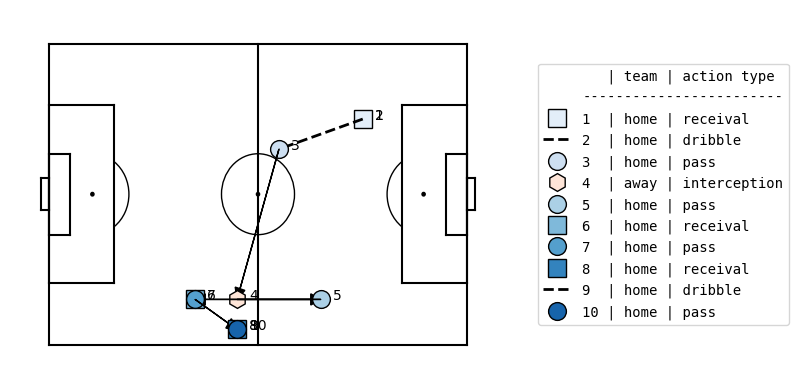

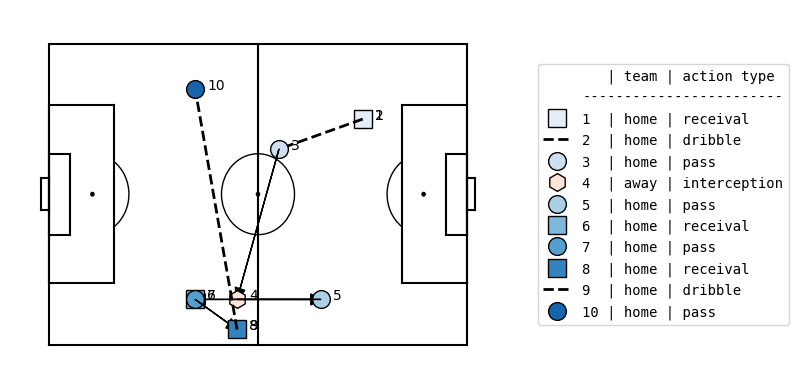

In [25]:
pid = 200

model.eval()
output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)
play = output[0,-1].item()
sequence = list(X_train[pid]) + [play]
plot_action_sequence([vocab[i] for i in sequence])

output = pred_markov(X_train[pid][-1])
sequence = list(X_train[pid]) + [output]
plot_action_sequence([vocab[i] for i in sequence])


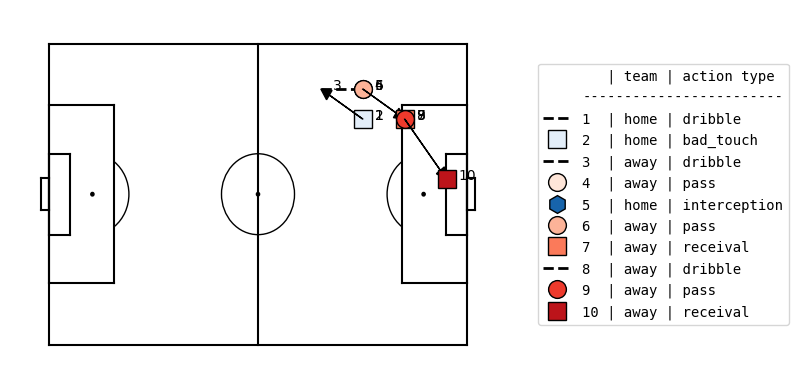

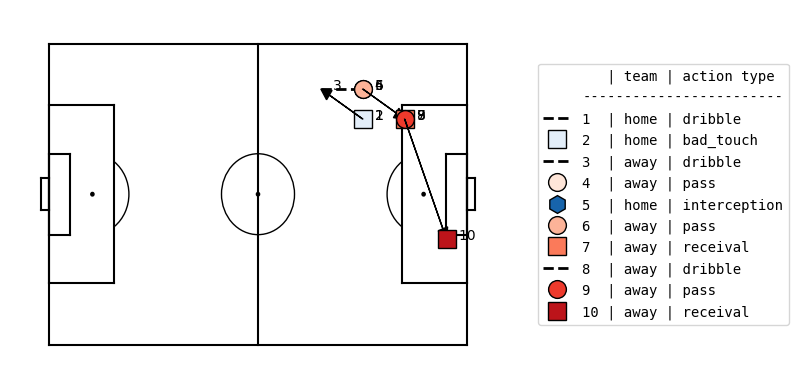

In [26]:
pid = 2000

model.eval()
output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)
play = output[0,-1].item()
sequence = list(X_train[pid]) + [play]
plot_action_sequence([vocab[i] for i in sequence])

output = pred_markov(X_train[pid][-1])
sequence = list(X_train[pid]) + [output]
plot_action_sequence([vocab[i] for i in sequence])
